<a href="https://colab.research.google.com/github/athiagarajan/cormac/blob/master/PytorchPneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#from torchinfo import summary
import numpy as np
import os

#from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
print(os.listdir("/content/drive/MyDrive/chest_xray"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

['test', 'train', 'val']


In [5]:
from os import walk
for (dirpath, dirnames, filenames) in walk("/content/drive/MyDrive/chest_xray"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#     print("File name: ", filenames)

Directory path:  /content/drive/MyDrive/chest_xray
Folder name:  ['test', 'train', 'val']
Directory path:  /content/drive/MyDrive/chest_xray/test
Folder name:  ['NORMAL', 'PNEUMONIA']
Directory path:  /content/drive/MyDrive/chest_xray/test/NORMAL
Folder name:  []
Directory path:  /content/drive/MyDrive/chest_xray/test/PNEUMONIA
Folder name:  []
Directory path:  /content/drive/MyDrive/chest_xray/train
Folder name:  ['NORMAL', 'PNEUMONIA']
Directory path:  /content/drive/MyDrive/chest_xray/train/NORMAL
Folder name:  []
Directory path:  /content/drive/MyDrive/chest_xray/train/PNEUMONIA
Folder name:  []
Directory path:  /content/drive/MyDrive/chest_xray/val
Folder name:  ['PNEUMONIA', 'NORMAL']
Directory path:  /content/drive/MyDrive/chest_xray/val/PNEUMONIA
Folder name:  []
Directory path:  /content/drive/MyDrive/chest_xray/val/NORMAL
Folder name:  []


In [6]:
import torch
from torchvision import datasets, transforms

# Define default PATH
PATH = '/content/drive/MyDrive/chest_xray'

In [7]:
# data_dir = 'Cat_Dog_data/train'
data_dir = PATH + '/train' # load from Kaggle

transform = transforms.Compose([transforms.Resize((256,256)),
                                #transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])# TODO: compose transforms here
dataset = datasets.ImageFolder(data_dir, transform=transform) # TODO: create the ImageFolder
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # TODO: use the ImageFolder dataset to create the DataLoader

In [8]:
# define helper.py 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable



def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<Axes: >

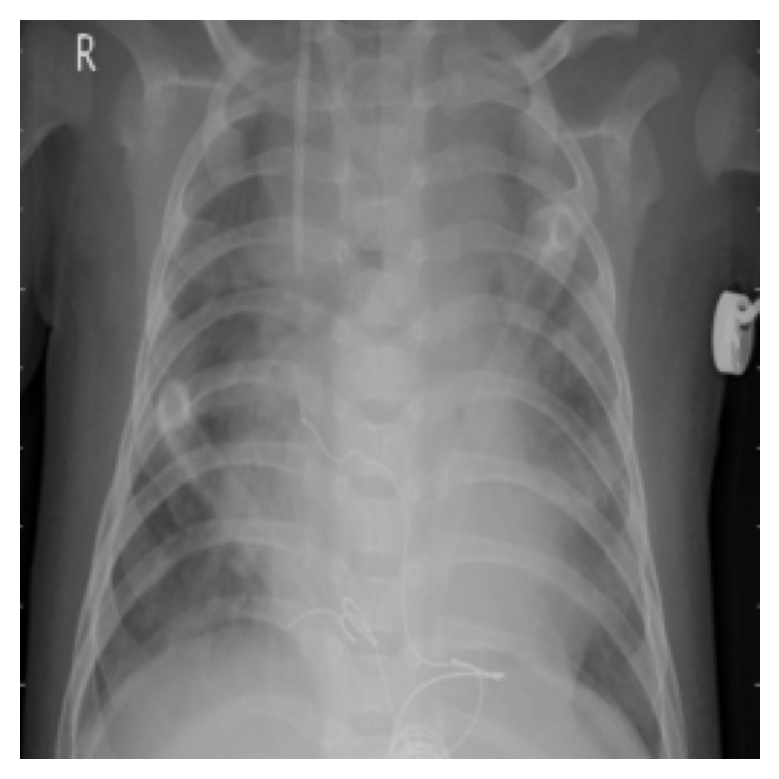

In [9]:
data_dir
# Run this to test your data loader
images, labels = next(iter(dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[5], normalize=False)

In [10]:
data_dir = PATH

# TODO: Define transforms for the training data and testing data
'''
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(256),
                                     transforms.ToTensor()])
'''
train_transforms = transforms.Compose([transforms.Grayscale(),transforms.Resize((256,256)),
                                transforms.CenterCrop(256),transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Grayscale(),transforms.Resize((256,256)),
                                transforms.CenterCrop(256),transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

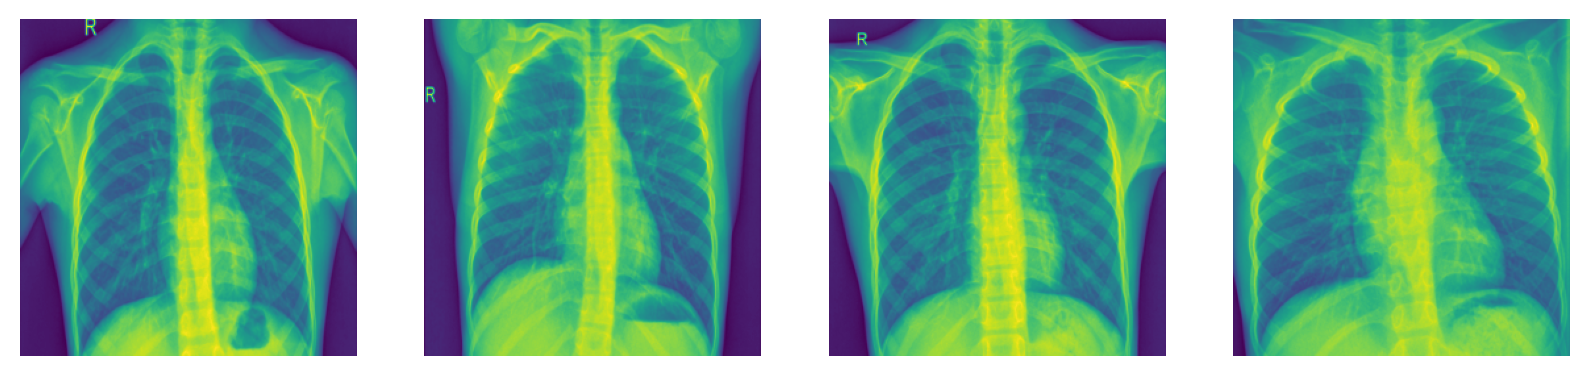

In [11]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: torch.Size([32])


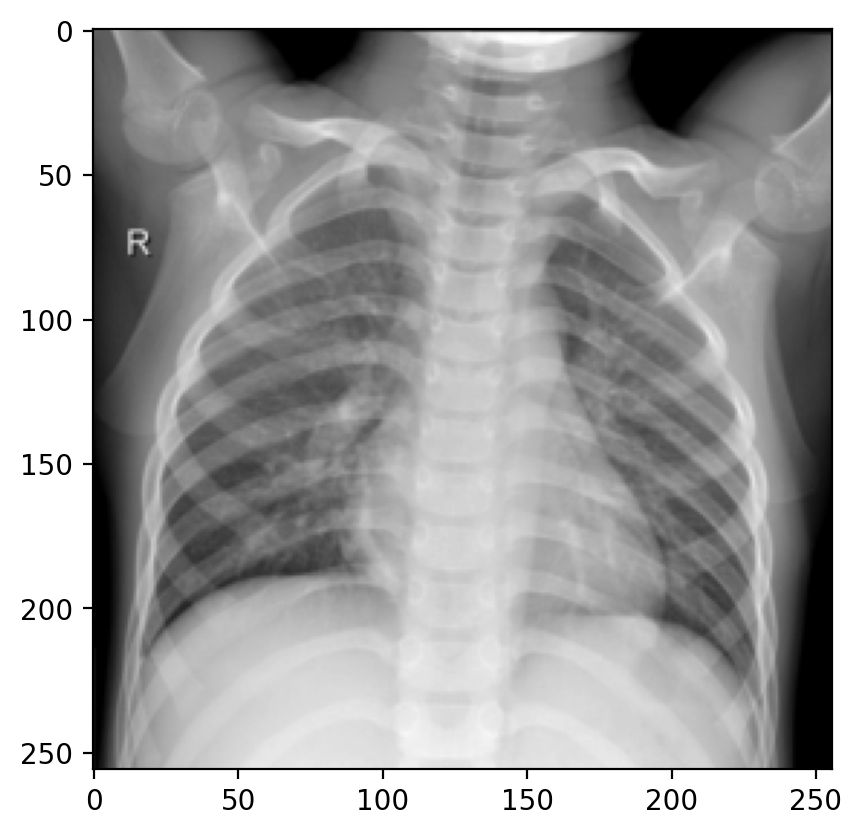

Label: 0


In [12]:
# Display image and label.
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[29].squeeze()
label = train_labels[29]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [13]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

In [14]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

In [15]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [ ]:
# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(256*256,2), # 784 inputs, 2 outputs
        nn.LogSoftmax())
print(net)

#hist = train(net,trainloader,testloader,epochs=1)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=2, bias=True)
  (2): LogSoftmax(dim=None)
)


In [17]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(256*256,100)
        self.out = nn.Linear(100,2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

#summary(net,input_size=(1,256,256),device='cpu')

hist = train(net,trainloader,testloader,epochs=10)

Epoch  0, Train acc=0.735, Val acc=0.567, Train loss=0.355, Val loss=0.129
Epoch  1, Train acc=0.550, Val acc=0.530, Train loss=0.111, Val loss=0.111
Epoch  2, Train acc=0.560, Val acc=0.497, Train loss=0.109, Val loss=0.111
Epoch  3, Train acc=0.502, Val acc=0.494, Train loss=0.109, Val loss=0.110
Epoch  4, Train acc=0.521, Val acc=0.503, Train loss=0.109, Val loss=0.110
Epoch  5, Train acc=0.527, Val acc=0.505, Train loss=0.109, Val loss=0.110
Epoch  6, Train acc=0.519, Val acc=0.500, Train loss=0.109, Val loss=0.110
Epoch  7, Train acc=0.521, Val acc=0.516, Train loss=0.109, Val loss=0.110
Epoch  8, Train acc=0.528, Val acc=0.524, Train loss=0.109, Val loss=0.110
Epoch  9, Train acc=0.524, Val acc=0.514, Train loss=0.109, Val loss=0.110


In [20]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(9*252*252,2)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()
hist = train(net,trainloader,testloader,epochs=10)

Epoch  0, Train acc=0.975, Val acc=0.625, Train loss=2.596, Val loss=916.336
Epoch  1, Train acc=0.895, Val acc=0.625, Train loss=152.987, Val loss=0.028
Epoch  2, Train acc=0.743, Val acc=0.625, Train loss=0.020, Val loss=0.026
Epoch  3, Train acc=0.743, Val acc=0.625, Train loss=0.020, Val loss=0.026
Epoch  4, Train acc=0.743, Val acc=0.625, Train loss=0.019, Val loss=0.025
Epoch  5, Train acc=0.743, Val acc=0.625, Train loss=0.019, Val loss=0.058
Epoch  6, Train acc=0.743, Val acc=0.625, Train loss=0.021, Val loss=0.025
Epoch  7, Train acc=0.743, Val acc=0.625, Train loss=0.019, Val loss=0.025
Epoch  8, Train acc=0.743, Val acc=0.625, Train loss=0.019, Val loss=0.025
Epoch  9, Train acc=0.743, Val acc=0.625, Train loss=0.019, Val loss=0.025


In [31]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(20*61*61,2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 20*61*61)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
hist = train(net,trainloader,testloader,epochs=5)

Epoch  0, Train acc=0.981, Val acc=0.625, Train loss=2.994, Val loss=120.157
Epoch  1, Train acc=0.908, Val acc=0.625, Train loss=35.433, Val loss=0.029
Epoch  2, Train acc=0.743, Val acc=0.625, Train loss=0.021, Val loss=0.026
Epoch  3, Train acc=0.743, Val acc=0.625, Train loss=0.020, Val loss=0.026
Epoch  4, Train acc=0.743, Val acc=0.625, Train loss=0.020, Val loss=0.026


In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120*57*57,120)
        self.fc2 = nn.Linear(120,2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        #print(x.shape)
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.950, Val acc=0.625, Train loss=0.008, Val loss=0.092
Epoch  1, Train acc=0.650, Val acc=0.625, Train loss=0.024, Val loss=0.021
Epoch  2, Train acc=0.743, Val acc=0.625, Train loss=0.018, Val loss=0.022
